In [1]:
import sys
from glob import glob

import h5py
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import preprocess_utils as pu

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import importlib
importlib.reload(du)

In [ ]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_72km = h5io['lon_72km'][...]
    lat_72km = h5io['lat_72km'][...]
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]

Split based on HRRR v3 and HRRR v4

Let obs time matches forecast lead time

Save a HDF5

In [ ]:
base_v3_s = datetime(2018, 7, 15)
base_v3_e = datetime(2020, 12, 2)

base_v4_s = datetime(2020, 12, 3)
base_v4_e = datetime(2022, 7, 15)

base_ref = datetime(2010, 1, 1)

In [ ]:
date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+180)]

In [8]:
year = 2010
file_torn = sorted(glob(report_dir+'{}_torn.csv'.format(year)))[0]

In [9]:
df = pd.read_csv(file_torn)

In [10]:
preserve_inds = [4, 5, 6, 10, 15, 16]

### 72km gridded version

In [11]:
from scipy.spatial import cKDTree

In [12]:
gridTree = cKDTree(list(zip(lon_72km.ravel(), lat_72km.ravel()))) #KDTree_wraper(xgrid, ygrid)

In [13]:
grid_shape = lon_72km.shape

In [14]:
preserve_inds = [4, 5, 6, 10, 15, 16]
# ['date', 'time', 'tz', 'mag', 'slat', 'slon']

L_v3 = len(date_list_v3)
L_v4 = len(date_list_v3)

for lead in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]:
    
    torn_grid_v3 = np.empty((L_v3,)+lon_72km.shape)
    torn_grid_v4 = np.empty((L_v4,)+lon_72km.shape)

    torn_grid_v3[...] = np.nan
    torn_grid_v4[...] = np.nan

    print('========== Processing lead time = {} =========='.format(lead))

    record_v3 = np.empty((L_v3, 3*30))*np.nan
    record_v4 = np.empty((L_v3, 3*30))*np.nan

    for y in range(2010, 2021):
        temp_day_old = 9999
        # Year info
        year_int = int(y)
        year = str(year_int)

        # Raw tornado files
        file_torn = sorted(glob(report_dir+'{}_torn.csv'.format(year)))[0]

        # import csv to pandas and then np.array
        df = pd.read_csv(file_torn)
        temp_array = df.iloc[:, preserve_inds].values

        # datetime and timezone processing
        L = len(temp_array)
        temp_tz = temp_array[:, 2]
        temp_dt_list = []
        flag_badboy = False

        for i in range(L):
            try:
                # the string can be converted to datetime object
                temp_localtime = datetime.strptime(temp_array[i, 0]+'|'+temp_array[i, 1], '%Y-%m-%d|%H:%M:%S')
                flag_badboy = False
            except:
                # the string cannot be converted; typically a "?"
                temp_localtime = np.nan
                flag_badboy = True

            # adjust timezones to UTC/GMT 
            if flag_badboy is False:
                temp_tz = temp_array[i, 2]
                if temp_tz == 3:
                    temp_localtime = temp_localtime + timedelta(hours=6) # <--- !!! "3" means CST
                elif temp_tz == 9:
                    temp_localtime = temp_localtime # "9" means GMT
                else:
                    temp_localtime = np.nan # otherwise doint know

            temp_dt_list.append(temp_localtime)

        # Insert in-situ reports into hourly, gridded data frames    
        ## convert slat slon to domain indices

        slon = temp_array[:, 5]
        slat = temp_array[:, 4]
        mag = temp_array[:, 3]

        flag_pick = np.logical_and(slon<-20, slat>5)

        slon = slon[flag_pick]
        slat = slat[flag_pick]
        mag = mag[flag_pick]

        L = len(slon)
        
        if L > 0:
            
            dist, indexes = gridTree.query(list(zip(np.array(slon), np.array(slat))))
            indx, indy = np.unravel_index(indexes, grid_shape)
            
            for i in range(L):

                # the time of a single record
                temp_datetime = temp_dt_list[i]
                temp_day = temp_datetime.day
                temp_hour = temp_datetime.hour

                temp_datetime_day = datetime(temp_datetime.year, temp_datetime.month, temp_day)

                if (temp_day_old == temp_day) is False:
                    count_v3 = 0
                    count_v4 = 0
                    temp_day_old = temp_day

                if temp_hour == lead:
                    diff_days = (temp_datetime_day - base_v4_s).days

                    if diff_days > 0:
                        #print('adding: {}'.format(temp_datetime))
                        
                        torn_grid_v4[diff_days, indx[i], indy[i]] = mag[i]
                        count_v4 += 1

                    else:
                        diff_days = (temp_datetime_day - base_v3_s).days
                        if diff_days > 0:
                            #print('adding: {}'.format(temp_datetime))
                            torn_grid_v3[diff_days, indx[i], indy[i]] = mag[i]
                            count_v3 += 1

                else:
                    continue

    tuple_save = (torn_grid_v3, torn_grid_v4)
    label_save = ['record_v3', 'record_v4']
    du.save_hdf5(tuple_save, label_save, save_dir_scratch, 'SPC_to_lead{}_72km.hdf'.format(lead))

========== Processing lead time = 0 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead0_72km.hdf
========== Processing lead time = 1 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead1_72km.hdf
========== Processing lead time = 2 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead2_72km.hdf
========== Processing lead time = 3 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead3_72km.hdf
========== Processing lead time = 4 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead4_72km.hdf
========== Processing lead time = 5 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead5_72km.hdf
========== Processing lead time = 6 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead6_72km.hdf
========== Processing lead time = 7 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead7_72km.hdf
========== Processing lead time = 8 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead8_72km.hdf
========== Processing lead time = 9 ==========
Save to /glade/scratch/ksh

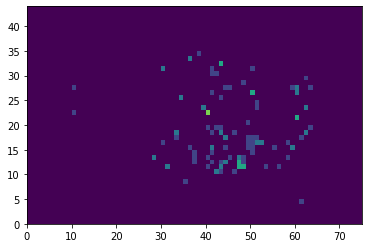

In [15]:
plt.pcolormesh(np.nansum(torn_grid_v3, axis=0), vmin=0, vmax=5)

### Pointed version

In [15]:
preserve_inds = [4, 5, 6, 10, 15, 16]
# ['date', 'time', 'tz', 'mag', 'slat', 'slon']

L_v3 = len(date_list_v3)
L_v4 = len(date_list_v3)

for lead in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]:

    print('========== Processing lead time = {} =========='.format(lead))

    record_v3 = np.empty((L_v3, 3*30))
    record_v3[...] = np.nan
    record_v4 = np.empty((L_v3, 3*30))
    record_v4[...] = np.nan

    for y in range(2010, 2021):
        temp_day_old = 9999
        # Year info
        year_int = int(y)
        year = str(year_int)

        # Raw tornado files
        file_torn = sorted(glob(report_dir+'{}_torn.csv'.format(year)))[0]

        # import csv to pandas and then np.array
        df = pd.read_csv(file_torn)
        temp_array = df.iloc[:, preserve_inds].values

        # datetime and timezone processing
        L = len(temp_array)
        temp_tz = temp_array[:, 2]
        temp_dt_list = []
        flag_badboy = False

        for i in range(L):
            try:
                # the string can be converted to datetime object
                temp_localtime = datetime.strptime(temp_array[i, 0]+'|'+temp_array[i, 1], '%Y-%m-%d|%H:%M:%S')
                flag_badboy = False
            except:
                # the string cannot be converted; typically a "?"
                temp_localtime = np.nan
                flag_badboy = True

            # adjust timezones to UTC/GMT 
            if flag_badboy is False:
                temp_tz = temp_array[i, 2]
                if temp_tz == 3:
                    temp_localtime = temp_localtime + timedelta(hours=6) # <--- !!! "3" means CST
                elif temp_tz == 9:
                    temp_localtime = temp_localtime # "9" means GMT
                else:
                    temp_localtime = np.nan # otherwise doint know

            temp_dt_list.append(temp_localtime)

        # Insert in-situ reports into hourly, gridded data frames    
        ## convert slat slon to domain indices

        slon = temp_array[:, 5]
        slat = temp_array[:, 4]
        mag = temp_array[:, 3]

        flag_pick = np.logical_and(slon<-20, slat>5)

        slon = slon[flag_pick]
        slat = slat[flag_pick]
        mag = mag[flag_pick]

        L = len(slon)

        for i in range(L):
            
            # the time of a single record
            temp_datetime = temp_dt_list[i]
            temp_day = temp_datetime.day
            temp_hour = temp_datetime.hour
            
            temp_datetime_day = datetime(temp_datetime.year, temp_datetime.month, temp_day)
            
            if (temp_day_old == temp_day) is False:
                count_v3 = 0
                count_v4 = 0
                temp_day_old = temp_day
            
            if temp_hour == lead:
                diff_days = (temp_datetime_day - base_v4_s).days

                if diff_days > 0:
                    #print('adding: {}'.format(temp_datetime))
                    record_v4[diff_days, 3*count_v4] = slon[i]
                    record_v4[diff_days, 3*count_v4+1] = slat[i]
                    record_v4[diff_days, 3*count_v4+2] = mag[i]
                    count_v4 += 1
                    
                else:
                    diff_days = (temp_datetime_day - base_v3_s).days
                    if diff_days > 0:
                        #print('adding: {}'.format(temp_datetime))
                        record_v3[diff_days, 3*count_v3] = slon[i]
                        record_v3[diff_days, 3*count_v3+1] = slat[i]
                        record_v3[diff_days, 3*count_v3+2] = mag[i]
                        count_v3 += 1

            else:
                continue

    tuple_save = (record_v3, record_v4)
    label_save = ['record_v3', 'record_v4']
    du.save_hdf5(tuple_save, label_save, save_dir_scratch, 'SPC_to_lead{}.hdf'.format(lead))


========== Processing lead time = 0 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead0.hdf
========== Processing lead time = 1 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead1.hdf
========== Processing lead time = 2 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead2.hdf
========== Processing lead time = 3 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead3.hdf
========== Processing lead time = 4 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead4.hdf
========== Processing lead time = 5 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead5.hdf
========== Processing lead time = 6 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead6.hdf
========== Processing lead time = 7 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead7.hdf
========== Processing lead time = 8 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead8.hdf
========== Processing lead time = 9 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead9.hdf
========== Processin

In [2]:
128*128*0.01

163.84